In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [2]:
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")

In [3]:
PPP_data.groupby(['sector', 'ssector']).size()

sector                 ssector                 
Energy                 Electricity                 3289
                       Natural Gas                  310
ICT                    Telecom                      134
Municipal Solid Waste  Collection and Transport      93
                       Integrated MSW                47
                       Treatment/ Disposal          278
Transport              Airports                     158
                       Railroads                    140
                       Seaports                     431
                       Toll Roads                  1164
Water and sewerage     Treatment plant              659
                       Water Utility                393
dtype: int64

In [4]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['shifted_country_experience_1'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

In [5]:
country_experience.shape

(3630, 3)

In [6]:
country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'sector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'sector', 'sector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.sector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'sector': sectors, 
                                                                              'sector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'sector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'sector': sectors, 
                                                                                  'sector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_sector_experience'] = country_sector_experience.groupby(['countrycode', 'sector'])['sector_experience'].cumsum()
country_sector_experience.drop(columns=['sector_experience'], inplace=True)

country_sector_experience['shifted_sector_experience_1'] = country_sector_experience.groupby(['countrycode', 'sector'])['cum_sector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_sector_experience'], inplace=True)

In [7]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [8]:
PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'sector'],
                          right_on=['countrycode', 'IY', 'sector'],
                          how='left')

In [9]:
PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)

PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])

PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country!='No') & (~PPP_data.foreign_country.isnull()), 'foreign_country'] = 'Yes'

PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'sector'],
                          right_on=['countrycode', 'IY', 'sector'],
                          how='left')

In [10]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [11]:
#copy data out.
data = PPP_data.copy()
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_country_experience_1',
               'shifted_sector_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'period',
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector'
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

In [12]:
# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'investment', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

In [129]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [54]:
PPP_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7096 entries, 0 to 7095
Data columns (total 63 columns):
IY                              7096 non-null int64
country                         7096 non-null object
Region                          7096 non-null object
income                          7096 non-null object
IDA                             7096 non-null object
FCY                             7096 non-null object
type                            7096 non-null object
stype                           7096 non-null object
status_n                        7096 non-null object
sector                          7096 non-null object
ssector                         7096 non-null object
Segment                         7096 non-null object
period                          5182 non-null float64
GGC                             5716 non-null object
TIGS                            5641 non-null object
private                         6817 non-null float64
physical                        6781 non-nul

In [17]:
X_train.columns

Index(['IY', 'Region', 'IDA', 'type', 'stype', 'sector', 'ssector', 'Segment',
       'period', 'GGC', 'private', 'physical', 'investment', 'pcapacity',
       'PRS', 'BS', 'UP', 'PublicDisclosure', 'bordercountries', 'countrycode',
       'adminregion', 'incomelevel', 'lendingtype', 'CPI2019', 'Renewables',
       'MLS', 'shifted_country_experience_1', 'shifted_sector_experience_1',
       'sponsor_number', 'foreign_country', 'GDP_per_capita', 'tax_as_GDP',
       'GDP_deflator', 'life_expectnacy', 'real_effective_change',
       'electric_consumption', 'domestic_credit_to_private', 'imports_as_GDP',
       'exports_as_GDP', 'control_of_corruption', 'government_effectiveness',
       'political_stability', 'regulatory_quality', 'rule_of_law',
       'voice_and_accountability'],
      dtype='object')

In [130]:
def fillna_nominal(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame().reset_index()
    # if no mode for current group, then fill with the mode in current column.
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test
def fillna_numerical(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mean_in_train = train.groupby(group_list)[column].mean().to_frame().reset_index()
    for i, rows in mean_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

In [131]:
missing_categorical = {'lendingtype': ['countrycode', 'ssector'],
                       'GGC': ['countrycode', 'ssector'],
                       'PRS': ['countrycode', 'ssector'],
                       'BS': ['countrycode', 'ssector'],
                       'adminregion': ['Region'],
                       'incomelevel': ['Region'],
                       'foreign_country': ['countrycode', 'ssector']}

for column, group_list in missing_categorical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_nominal(X_train, X_test, group_list, column)

missing_numerical = {'period': ['stype', 'sector', 'Region', 'countrycode'],
                     'pcapacity': ['stype', 'sector', 'Region', 'countrycode'],
                     'private': ['stype', 'ssector', 'countrycode'],
                     'physical': ['stype', 'ssector', 'countrycode'],
                     'investment': ['stype', 'ssector', 'countrycode'],
                     'tax_as_GDP': ['Region'],
                     'real_effective_change': ['Region'],
                     'domestic_credit_to_private': ['Region'],
                     'rule_of_law': ['Region'],
                     'imports_as_GDP': ['Region'],
                     'exports_as_GDP': ['Region'],
                     'electric_consumption': ['Region'],
                     'sponsor_number': ['countrycode', 'ssector']}

for column, group_list in missing_numerical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_numerical(X_train, X_test, group_list, column)

In [132]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [133]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [134]:
X_bal, y_bal = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
# ###########
balanced = X_bal.join(y_bal)
bal_corr = balanced.corr()

In [17]:
plt.figure(figsize=(8,30))
sorted_correlation =  bal_corr.sort_values(by='status_n', ascending=True)
#plt.barh(sorted_correlation.status_n[:-2].index, sorted_correlation.status_n[:-2])

<Figure size 576x2160 with 0 Axes>

In [18]:
correlated_with_status = sorted_correlation.status_n.to_frame()
correlated_with_status['abs_status'] = correlated_with_status.status_n.abs()
correlated_with_status = correlated_with_status.sort_values(by='abs_status', ascending=True)
correlated_with_status = correlated_with_status.drop(['Segment_Electricity generation natural gas ', 'status_n'])

In [24]:
correlated_with_status[correlated_with_status.status_n > 0]

,status_n,abs_status
political_stability,0.000630,0.000630
Segment_Electricity distribution,0.001030,0.001030
Segment_Freight and passenger,0.005709,0.005709
period,0.009456,0.009456
regulatory_quality,0.010422,0.010422
Segment_Fixed assets and passenger,0.013337,0.013337
Segment_Highway,0.020335,0.020335
adminregion_LAC,0.028923,0.028923
Region_LAC,0.028923,0.028923
incomelevel,0.039085,0.039085


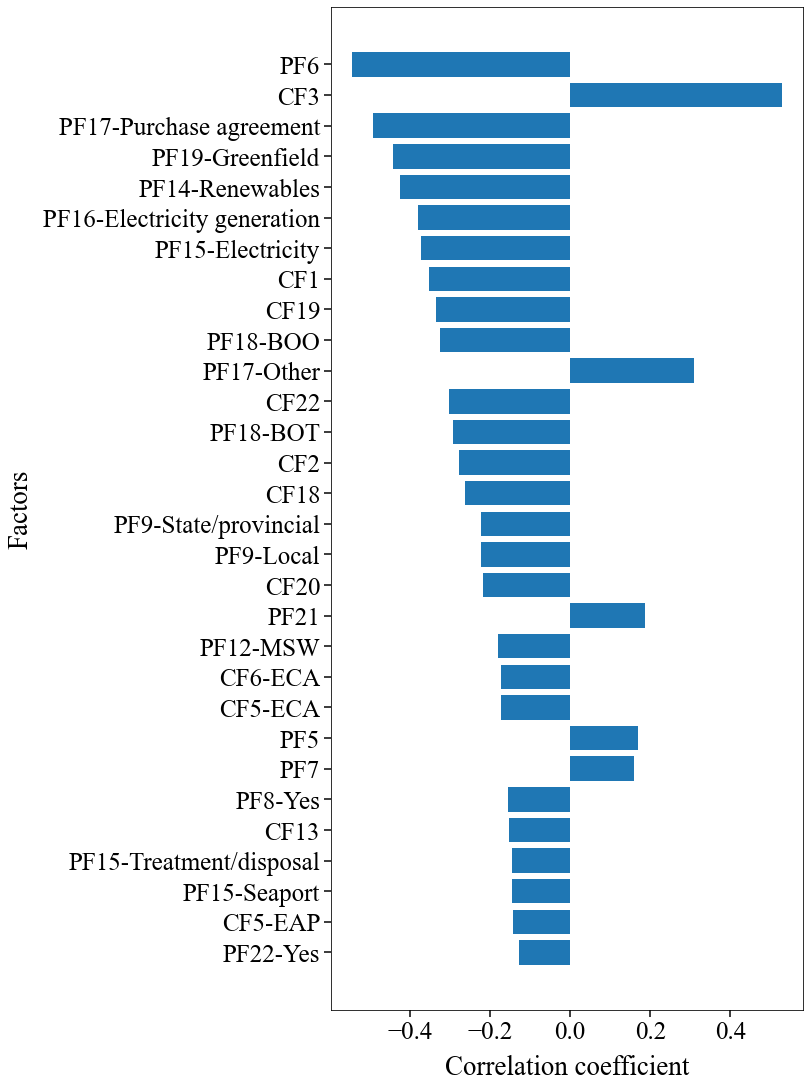

In [30]:
fig = plt.figure(figsize=(8,17))
ax = fig.add_subplot(111)   

selected_factors = correlated_with_status.tail(30)
yaxis = ['PF6', 'CF3', 'PF17-Purchase agreement', 'PF19-Greenfield', 'PF14-Renewables',
         'PF16-Electricity generation', 'PF15-Electricity', 'CF1', 'CF19', 'PF18-BOO',
         'PF17-Other', 'CF22', 'PF18-BOT', 'CF2', 'CF18', 
         'PF9-State/provincial', 'PF9-Local', 'CF20', 'PF21', 'PF12-MSW', 
         'CF6-ECA', 'CF5-ECA', 'PF5', 'PF7', 'PF8-Yes', 
         'CF13', 'PF15-Treatment/disposal', 'PF15-Seaport', 'CF5-EAP', 'PF22-Yes']
yaxis.reverse()
ax.barh(yaxis, selected_factors.status_n)

ax.set_xlabel("Correlation coefficient", fontsize=27, fontname='times new roman', labelpad=10)
ax.set_ylabel("Factors", fontsize=27, fontname='times new roman', labelpad=10)
ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
#plt.savefig(r"C:\PPP\Thesis\Paper3\correlation.png", dpi=100)

In [55]:
X_combine = X_train.join(y_train)
X_corr = X_combine.corr()

X_sorted_correlation =  X_corr.sort_values(by='status_n', ascending=True)
X_correlated_with_status = X_sorted_correlation.status_n.to_frame()
X_correlated_with_status['abs_status'] = X_correlated_with_status.status_n.abs()
X_correlated_with_status = X_correlated_with_status.sort_values(by='abs_status', ascending=True)
X_correlated_with_status = X_correlated_with_status.drop(['Segment_Electricity generation natural gas ', 'status_n', 'IY'])

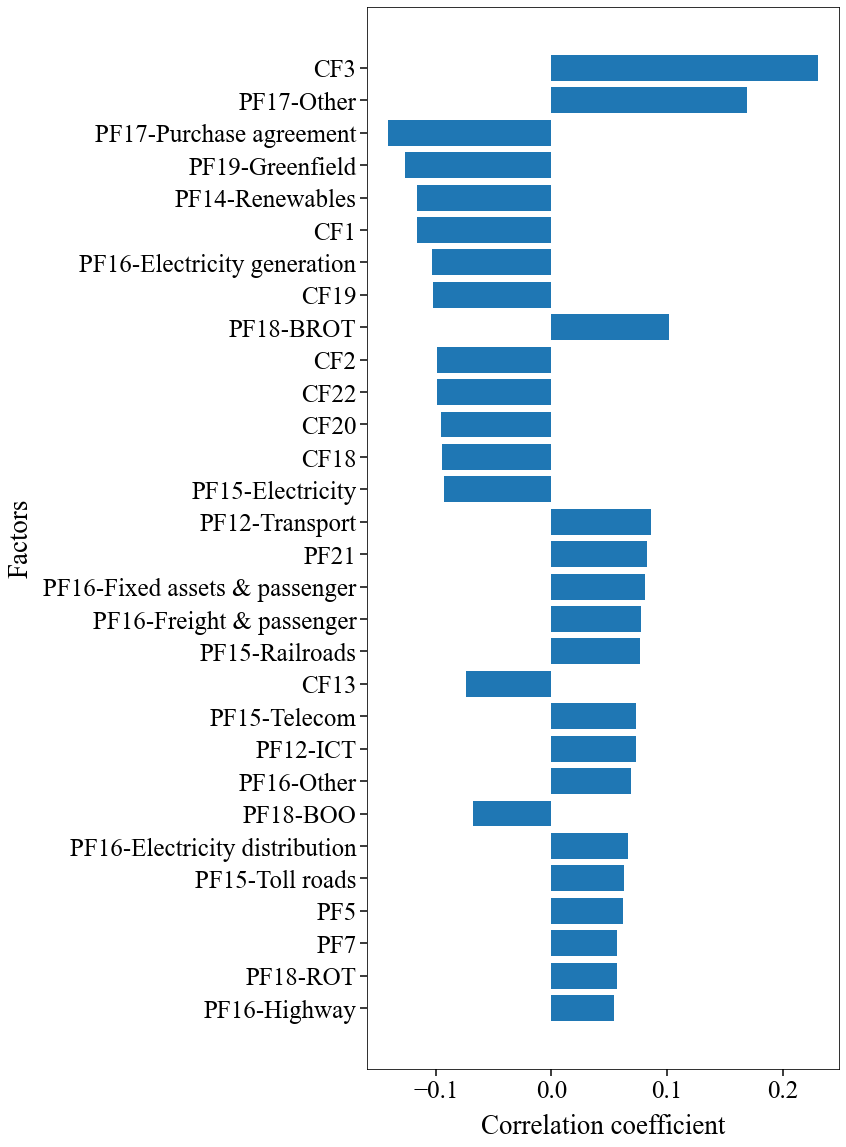

In [102]:
fig = plt.figure(figsize=(8,18))
ax = fig.add_subplot(111)   

selected_factors = X_correlated_with_status.tail(30)
yaxis = ['CF3', 'PF17-Other', 'PF17-Purchase agreement', 'PF19-Greenfield', 'PF14-Renewables',
         'CF1', 'PF16-Electricity generation', 'CF19', 'PF18-BROT', 'CF2',
         'CF22', 'CF20', 'CF18', 'PF15-Electricity', 'PF12-Transport', 
         'PF21', 'PF16-Fixed assets & passenger', 'PF16-Freight & passenger', 'PF15-Railroads', 'CF13', 
         'PF15-Telecom', 'PF12-ICT', 'PF16-Other', 'PF18-BOO', 'PF16-Electricity distribution', 
         'PF15-Toll roads', 'PF5', 'PF7', 'PF18-ROT', 'PF16-Highway']

yaxis.reverse()
ax.barh(yaxis, selected_factors.status_n)

ax.set_xlabel("Correlation coefficient", fontsize=27, fontname='times new roman', labelpad=10)
ax.set_ylabel("Factors", fontsize=27, fontname='times new roman', labelpad=10)
ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
#plt.savefig(r"C:\PPP\Thesis\Paper3\correlation_before_smote.png", dpi=100)

In [135]:
data_dict = {}
#0, 6, 0.02
for threshold in [0.05]:
    for out in [8]:
        no_outliers = pd.DataFrame(balanced.copy())
        cols = bal_corr.status_n.index[:-1]
        for col in cols:
            correlation = bal_corr.loc['status_n', col]
            if np.abs(correlation) > threshold:
                nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
                frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
                all_values = no_outliers.loc[:,col]
                q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
                iqr = q75 - q25
                cutoff = iqr * out
                lower, upper = q25 - cutoff, q75 + cutoff
                if correlation > 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
                elif correlation < 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)        
        for i in [0.04]:
            data_list = []
            key =(threshold, out, i)
            feat_sel =pd.DataFrame(no_outliers.copy())
            new_corr = feat_sel.corr()
            for col in new_corr.status_n.index[:-1]:
                if np.abs(new_corr.loc['status_n', col]) < i:
                    feat_sel.drop(columns=col, inplace=True)

            X_final_train = feat_sel.drop('status_n', 1)
            y_final_train = feat_sel.status_n
            X_final_train, y_final_train = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
                               X_final_train,
                               y_final_train)

            X_final_test = X_test[X_final_train.columns]
            y_final_test = y_test
            data_list.append([X_final_train, y_final_train, X_final_test, y_final_test])
            data_dict[key] = data_list

In [22]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    ax.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    ax.set_xlabel("True Positive Rate", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("False Positive Rate", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\ROC.png", dpi=1000)

def plot_recall_precision(y_true, y_pred):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--')
    ax.set_xlabel("Recall", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("Precision", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\precision-recall.png", dpi=1000)


def plot_cm(labels, predictions, p):
    cm = confusion_matrix(labels, predictions > p)
    new_cm = np.array([[0, 0], [0, 0]])
    new_cm[0, 0] = cm[1, 1]
    new_cm[0, 1] = cm[0, 1]
    new_cm[1, 0] = cm[1, 0]
    new_cm[1, 1] = cm[0, 0]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)  

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(new_cm, annot=True, fmt='.0f', cmap=cmap, annot_kws={"size":20, 'fontname': 'times new roman'}, cbar=False)

    
    plt.yticks([0.5,1.5], [ 'fail', 'success'],va='center')
    plt.xticks([0.5,1.5], [ 'fail', 'success'],va='center')
    
    ax.set_xlabel("True label", fontsize=27, fontname='times new roman')
    ax.set_ylabel("Predicted result", fontsize=27, fontname='times new roman')
    
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='both', length=0, labelsize=25, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\confusion matrix.png", dpi=1000)
    
    
def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')

In [77]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.calibration import CalibratedClassifierCV

In [153]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)

param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 20)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
random_forest_result = []
for k,v in data_dict.items():
    clf_random_grid.fit(v[0][0], v[0][1])
    pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                          v[0][2],
                                          v[0][3],                                      
                                          method='predict_proba',
                                          cv=5)
    random_forest_result.append(pred_clf_upsample)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.9s finished


In [154]:
result = random_forest_result.copy()

In [155]:
len(result)

1

In [156]:
clf_random_grid.best_params_

{'n_estimators': 862,
 'min_samples_split': 19,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 55,
 'bootstrap': False}

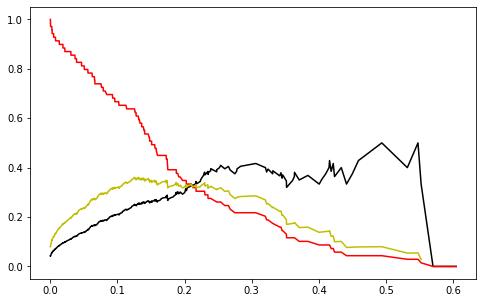

In [157]:
plot_threshold_graph(y_test, result[0][:,1])

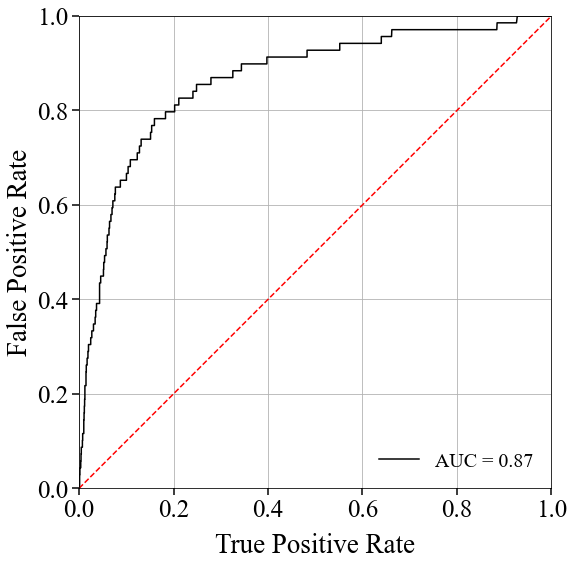

In [158]:
plot_roc(y_test, result[0][:,1])

No handles with labels found to put in legend.


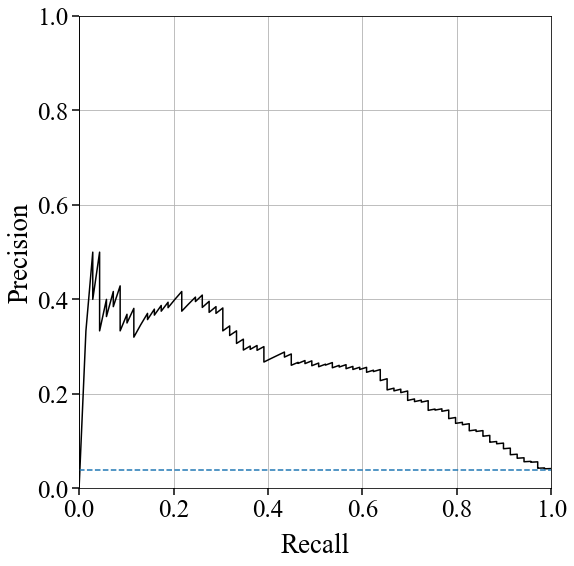

In [159]:
for i in result:
    plot_recall_precision(y_test, i[:,1])

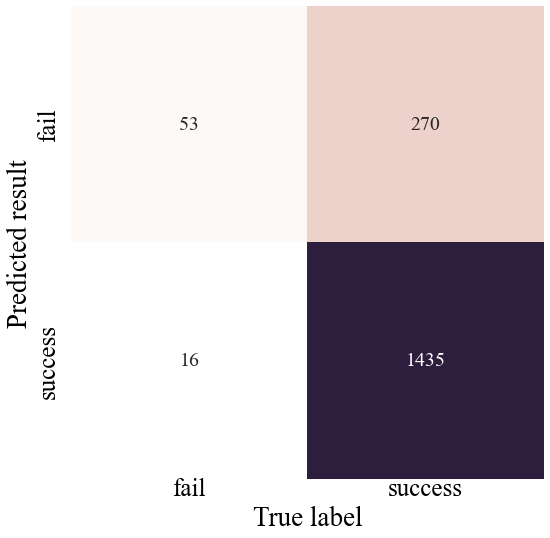

In [166]:
plot_cm(y_test, result[0][:, 1], 0.063)

In [99]:
np.sort(result[0][:, 1])

array([0.        , 0.        , 0.        , ..., 0.55250304, 0.5702371 ,
       0.60474508])

In [64]:
#feature importance
for k,v in data_dict.items():
    fi = pd.DataFrame({'feature': list(v[0][0].columns),
                   'importance': clf_random_grid.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [30]:
v[0][0].shape

(4752, 93)

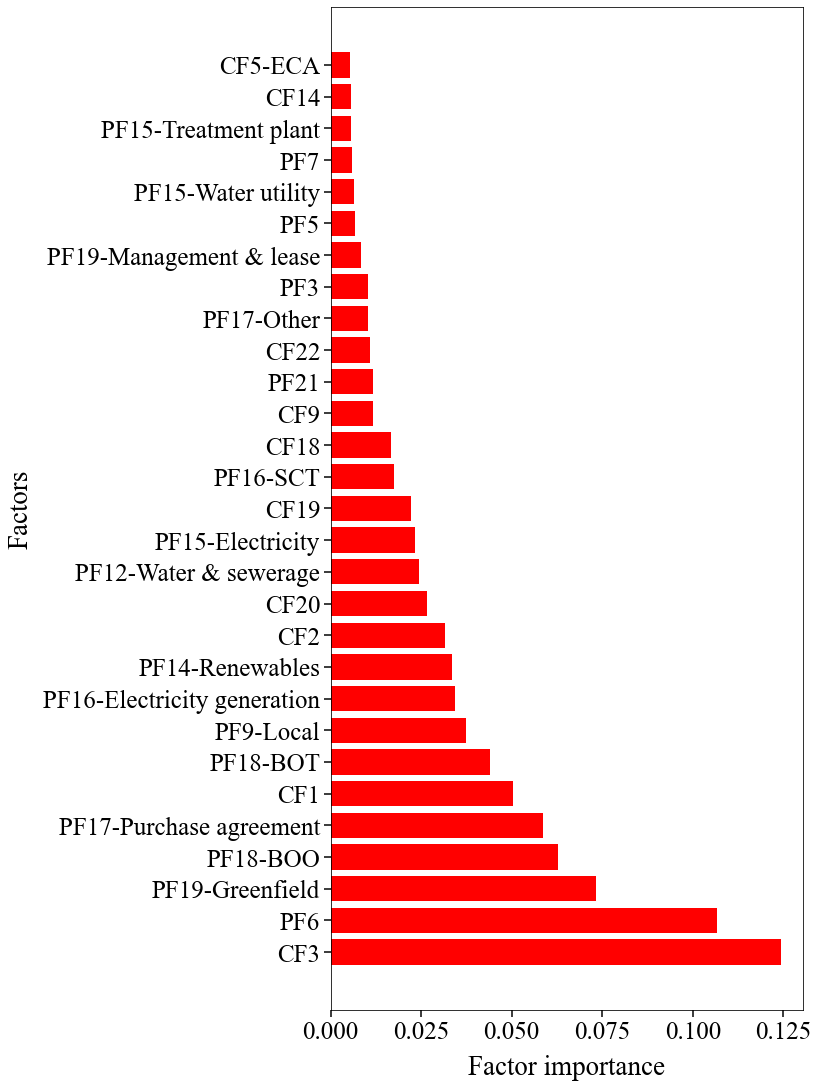

In [40]:
feature_importance_barth = fi.head(30)
fig = plt.figure(figsize=(8,17))
ax = fig.add_subplot(111)   
yaxis = ['CF3', 'PF6', 'PF19-Greenfield', 'PF18-BOO', 'PF17-Purchase agreement',
         'CF1', 'PF18-BOT', 'PF9-Local', 'PF16-Electricity generation', 'PF14-Renewables',
         'CF2', 'CF20', 'PF12-Water & sewerage', 'PF15-Electricity', 'CF19', 
         'PF16-SCT', 'CF18', 'CF9', 'PF21', 'CF22', 
         'PF17-Other', 'PF3', 'PF19-Management & lease', 'CF3', 'PF5', 
         'PF15-Water utility', 'PF7', 'PF15-Treatment plant', 'CF14', 'CF5-ECA']
ax.barh(yaxis, feature_importance_barth.importance, color='r')
ax.set_xlabel("Factor importance", fontsize=27, fontname='times new roman', labelpad=10)
ax.set_ylabel("Factors", fontsize=27, fontname='times new roman', labelpad=10)
ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
plt.savefig(r"C:\PPP\Thesis\Paper3\importance.png", dpi=100)

In [76]:
failure_factors = X_correlated_with_status[X_correlated_with_status.status_n > 0]
failure_factors = failure_factors.reset_index()

In [88]:
new_fi = fi.drop([0])
importance_of_failure_factors = failure_factors.merge(new_fi,
                                                      left_on=['index'],
                                                      right_on=['feature'],
                                                      how='left')
importance_of_failure_factors = importance_of_failure_factors.dropna()
importance_of_failure_factors = importance_of_failure_factors.sort_values(by=['importance'], ascending=True)

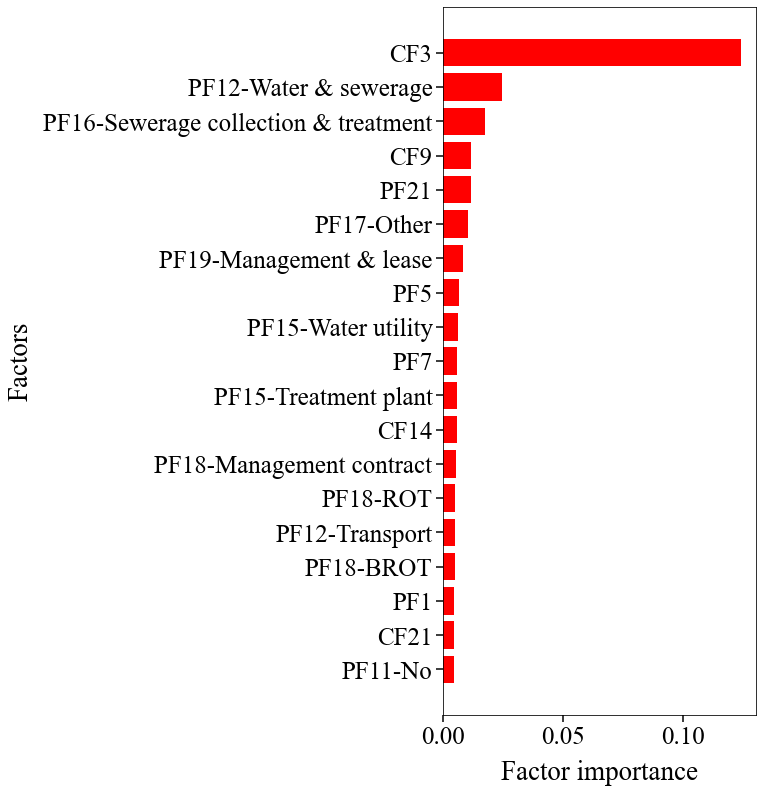

In [103]:
feature_importance_barth = importance_of_failure_factors.tail(19)
fig = plt.figure(figsize=(5.3,12))
ax = fig.add_subplot(111)   
yaxis = ['CF3', 'PF12-Water & sewerage', 'PF16-Sewerage collection & treatment', 'CF9', 'PF21',
         'PF17-Other', 'PF19-Management & lease', 'PF5', 'PF15-Water utility', 'PF7',
         'PF15-Treatment plant', 'CF14', 'PF18-Management contract', 'PF18-ROT', 'PF12-Transport',
         'PF18-BROT', 'PF1', 'CF21', 'PF11-No']
yaxis.reverse()
ax.barh(yaxis, feature_importance_barth.importance, color='r')
ax.set_xlabel("Factor importance", fontsize=27, fontname='times new roman', labelpad=10)
ax.set_ylabel("Factors", fontsize=27, fontname='times new roman', labelpad=10)
ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
#plt.savefig(r"C:\PPP\Thesis\Paper3\importance.png", dpi=100)

In [91]:
importance_of_failure_factors

,index,status_n,abs_status,feature,importance
19,Segment_Runway and terminal,0.017289,0.017289,Segment_Runway and terminal,0.000000e+00
29,Segment_Tunnel,0.029945,0.029945,Segment_Tunnel,0.000000e+00
24,"Segment_Fixed assets, freight and passenger",0.025968,0.025968,"Segment_Fixed assets, freight and passenger",0.000000e+00
7,lendingtype_IDB,0.002812,0.002812,lendingtype_IDB,0.000000e+00
13,Segment_Freight,0.012243,0.012243,Segment_Freight,0.000000e+00
21,"Segment_Electricity distribution, generation, ...",0.020547,0.020547,"Segment_Electricity distribution, generation, ...",0.000000e+00
15,IDA_IDA,0.015300,0.015300,IDA_IDA,0.000000e+00
16,lendingtype_IDX,0.015300,0.015300,lendingtype_IDX,0.000000e+00
49,Segment_Fixed assets and passenger,0.080962,0.080962,Segment_Fixed assets and passenger,2.676270e-09
47,ssector_Railroads,0.076914,0.076914,ssector_Railroads,1.882536e-08
